In [17]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label

client = Client(processes=False)
df = dd.read_csv("../data/raw/Eluvio_DS_Challenge.csv", blocksize=64000000)
df.time_created = df.time_created.astype('uint32')
df.up_votes = df.up_votes.astype('uint16')
df.down_votes = df.down_votes.astype('uint16')

df = client.persist(df)
print df.dtypes

time_created    uint32
date_created    object
up_votes        uint16
down_votes      uint16
title           object
over_18           bool
author          object
category        object
dtype: object


In [47]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
sampled_df = df.sample(frac=0.05)
sampled_titles = sampled_df['title'].compute().values
sampled_up_votes = sampled_df['up_votes'].compute().values
print "title_sample:{}".format(sampled_titles)
#print "title_sample.tolist:{}".format(sampled_titles.tolist())

print('Title before vectorization: {}'.format(sampled_titles[1]))

sampled_document_term_matrix = count_vectorizer.fit_transform(sampled_titles)

print('Title after vectorization: \n{}'.format(sampled_document_term_matrix[1]))
# dictionary = corpora.Dictionary([sampled_titles])
# doc_term_matrix = [dictionary.doc2bow(doc) for doc in [sampled_titles]]
# print "doc_term_matrix:{}".format(doc_term_matrix)

def tokenize_titles(titles):

    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for title in titles:
        raw = title.decode('utf-8').strip().lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [token for token in tokens if not token in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

words = tokenize_titles(sampled_titles)
dictionary = corpora.Dictionary(words)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in words]
# print "words:{}".format(words)
# print "dictionary:{}".format(dictionary)
# print "doc_term_matrix:{}".format(doc_term_matrix)

title_sample:['Bumblebees exposed to controversial pesticides collect just half the pollen they would otherwise harvest, according to new research, depriving their growing young of their only source of protein. [x-post /r/environment]'
 'French surgeon returning from Aleppo says half of rebels are non-Syrians wishing to set up an Islamic state with sharia law to become part of the world Emirate'
 'Spain unemployment drops to 23 per cent leaving the total number of unemployed at a rounded 5.4 million.'
 ... 'Brussels Cancels New Year s Eve Festivities Over Terror Threat'
 'North Korea has deployed one or two intermediate-range ballistic missiles on the east coast, possibly preparing for launch on or around Friday, the anniversary of the birth of the country s founder, South Korea s Yonhap news agency reported.'
 'At least 20 civilians killed and scores wounded in Turkish offensive in Syria']
Title before vectorization: French surgeon returning from Aleppo says half of rebels are non-Syr

determining the number of topics
coherence scores: [0.13794209995718382, 0.14786255289473202, 0.16727735138227734, 0.2001058968347123, 0.1935969701234493, 0.23417909848576635, 0.23354471315390393, 0.22485539254983852, 0.24334872129271265, 0.22607781673523544, 0.22354430218231233, 0.24169512041518704, 0.25245271412557885, 0.23660558195796616, 0.25616564584214646, 0.26204198094629283, 0.2530144253878493, 0.2698127322213288, 0.26525398174247244, 0.25713400030279826, 0.25624340841561394, 0.26478097734391715, 0.2723343574283494, 0.26707720843480864, 0.2709259449383489, 0.26515764929488617, 0.2753737090339853, 0.26369345233881003, 0.26869487360729427, 0.2636881483028416, 0.2546149563394089, 0.26411640446789514, 0.2549003287707768, 0.2631808302431786, 0.2557105018742695, 0.2546824117351498, 0.2548159666615642, 0.2581448380573361, 0.2652441646810885, 0.25330900002295487, 0.2509081611404284, 0.24827101793249126, 0.2500914172083694, 0.25172974983201146, 0.24729102897978592, 0.24462974189093928, 

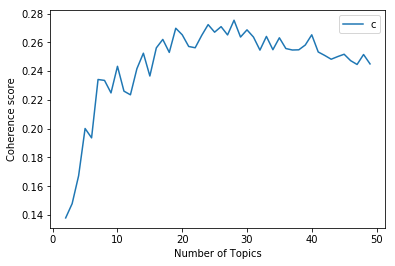

In [4]:
print "determining the number of topics"
def compute_plot_coherence_values(doc_term_matrix, stop, start=2, step=1):

    coherence_values = []
    model_list = []
    num_options = range(start, stop, step)
    for num_topics in num_options:
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    print "coherence scores: {}".format(coherence_values)
    print "plotting coherence score for different number of topics" 
    plt.plot(num_options, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence scores"), loc='best')
    plt.show()

compute_plot_coherence_values(doc_term_matrix, 50, 2, 1)

In [5]:
print "setting num of topics to be 20"
n_topics = 20
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(sampled_document_term_matrix)
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

top_n_words_lsa = get_top_n_words(10, lsa_keys, sampled_document_term_matrix, count_vectorizer)
for idx, top_words in enumerate(top_n_words_lsa):
    print("Topic {}: ".format(idx + 1), ','.join(top_words.split(' ')))

setting num of topics to be 20
('Topic 1: ', u'killed,says,attack,isis,pakistan,said,chinese,say,egypt,saudi')
('Topic 2: ', u'china,sea,chinese,south,japan,military,new,world,russia,india')
('Topic 3: ', u'south,north,korea,new,korean,africa,african,people,kim,test')
('Topic 4: ', u'korea,north,says,south,korean,nuclear,missile,kim,japan,jong')
('Topic 5: ', u'new,says,zealand,iran,minister,york,government,times,president,law')
('Topic 6: ', u'syria,russia,assad,war,al,turkey,chemical,isis,rebels,russian')
('Topic 7: ', u'iran,nuclear,deal,israel,iranian,talks,world,plant,israeli,netanyahu')
('Topic 8: ', u'russia,ukraine,putin,crimea,sanctions,russian,says,world,moscow,eu')
('Topic 9: ', u'world,news,war,cup,largest,new,people,says,climate,global')
('Topic 10: ', u'president,government,egypt,venezuela,said,country,election,vote,protests,obama')
('Topic 11: ', u'israel,gaza,israeli,palestinian,hamas,palestinians,bank,west,jerusalem,jewish')
('Topic 12: ', u'police,protesters,french,ar

visualizing num of titles under each topic
lsa_categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
lsa_counts:[10760, 1145, 239, 938, 748, 647, 829, 705, 702, 689, 1055, 760, 528, 670, 1147, 399, 301, 408, 1763, 1029]


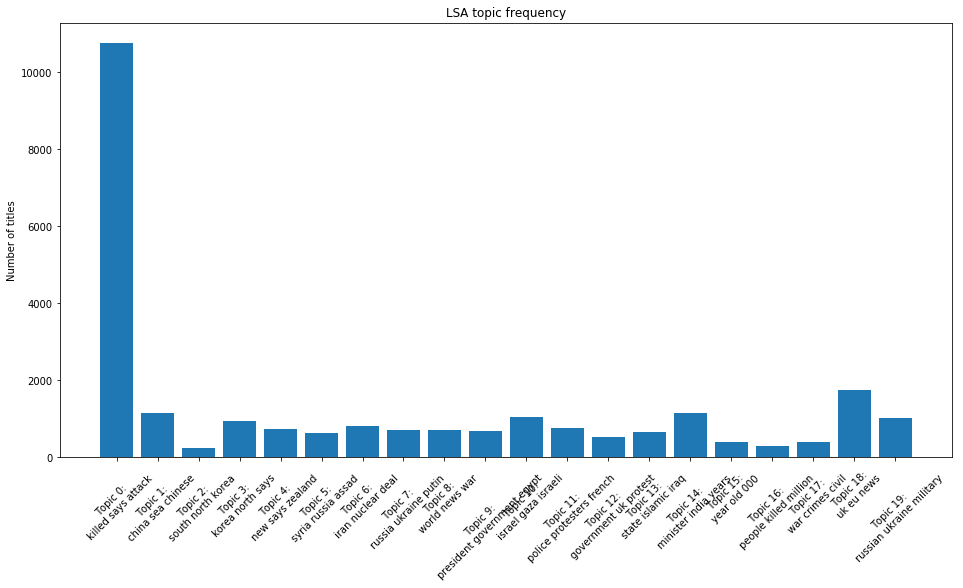

In [23]:
print "visualizing num of titles under each topic"
top_3_words = get_top_n_words(3, lsa_keys, sampled_document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
print "lsa_categories:{}".format(lsa_categories)
print "lsa_counts:{}".format(lsa_counts)
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
plt.xticks(rotation=45)
ax.set_xticklabels(labels);
ax.set_ylabel('Number of titles');
ax.set_title('LSA topic frequency');
plt.show()

In [6]:
print "use t-SNE to visualize LSA high dimensional dataset"
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

use t-SNE to visualize high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 25462 samples in 0.044s...
[t-SNE] Computed neighbors for 25462 samples in 32.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25462
[t-SNE] Computed conditional probabilities for sample 2000 / 25462
[t-SNE] Computed conditional probabilities for sample 3000 / 25462
[t-SNE] Computed conditional probabilities for sample 4000 / 25462
[t-SNE] Computed conditional probabilities for sample 5000 / 25462
[t-SNE] Computed conditional probabilities for sample 6000 / 25462
[t-SNE] Computed conditional probabilities for sample 7000 / 25462
[t-SNE] Computed conditional probabilities for sample 8000 / 25462
[t-SNE] Computed conditional probabilities for sample 9000 / 25462
[t-SNE] Computed conditional probabilities for sample 10000 / 25462
[t-SNE] Computed conditional probabilities for sample 11000 / 25462
[t-SNE] Computed conditional probabilities for sample 12000 / 25462


tsne_lsa_vectors:[[ 10.5717945  41.109364 ]
 [-62.61524     8.471627 ]
 [-62.651894    9.8053055]
 ...
 [ 77.87129    16.890537 ]
 [ 12.831247  -27.489437 ]
 [ 23.35356   -42.590755 ]], 25462 vectors


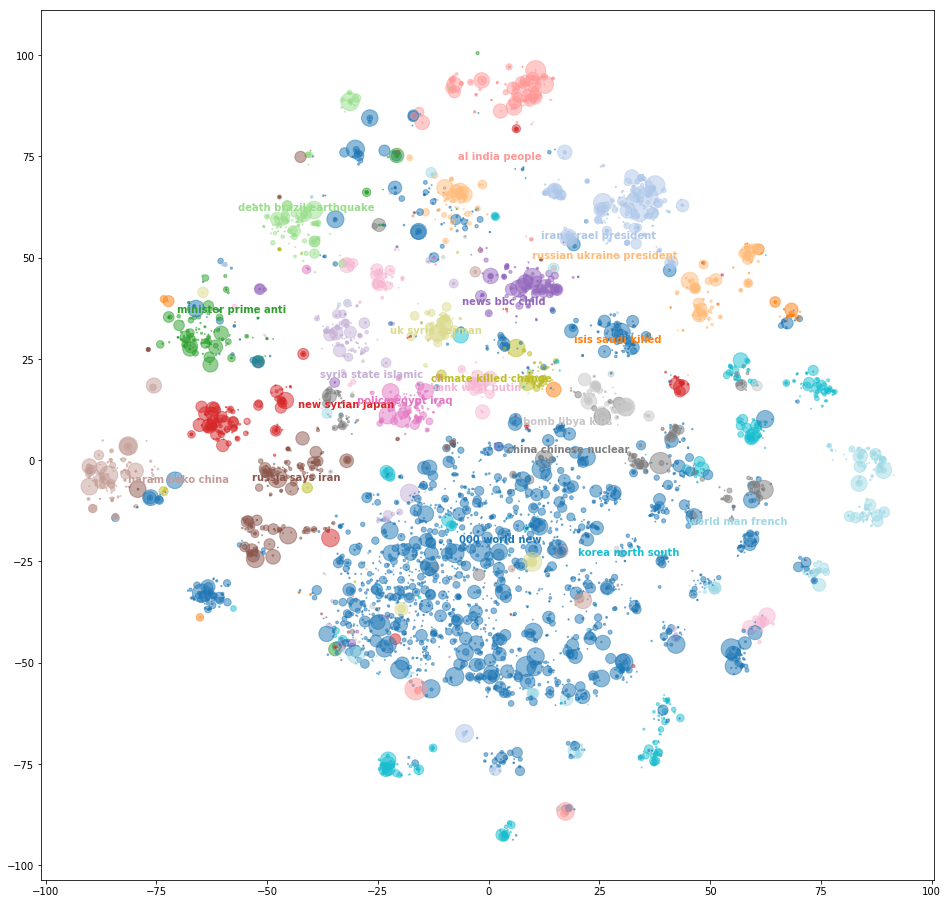

In [53]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    centroid_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        centroid_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        centroid_topic_vectors.append(centroid_article_in_that_topic)
    return centroid_topic_vectors
print "tsne_lsa_vectors:{}, {} vectors".format(tsne_lsa_vectors, len(tsne_lsa_vectors))
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)
colormap = np.array([
    "#1f77b5", "#aec7e9", "#ff7f0f", "#ffbb79", "#2ca02d",
    "#98df8b", "#d62729", "#ff9897", "#9467be", "#c5b0d6",
    "#8c564c", "#c49c95", "#e377c3", "#f7b6d3", "#7f7f80",
    "#c7c7c8", "#bcbd23", "#dbdb8e", "#17bed0", "#9edae6" ])
colormap = colormap[:n_topics]
proportion = 20;
sampled_up_votes_sizes = sampled_up_votes / proportion;
fig, ax = plt.subplots(figsize=(16,16))
plt.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1],
            color=colormap[lsa_keys],
            marker='o', s=sampled_up_votes_sizes, alpha=0.5)
for t in range(n_topics):
    plt.text(lsa_mean_topic_vectors[t][0],
             lsa_mean_topic_vectors[t][1],
             top_3_words[t], color=colormap[t],
             horizontalalignment='center', weight='bold')
plt.show()

In [18]:
print "Try LDA"
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=1)
lda_topic_matrix = lda_model.fit_transform(sampled_document_term_matrix)

Try LDA
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [21]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_10_words_lda = get_top_n_words(10, lda_keys, sampled_document_term_matrix, count_vectorizer)

print "top 10 topic words by LDA:"
for idx, topic in enumerate(top_10_words_lda):
    print("Topic {}: ".format(idx + 1), topic)


top 10 topic words by LDA:
('Topic 1: ', u'000 world new global pakistan women china 10 internet people')
('Topic 2: ', u'iran israel president crisis election nuclear egypt vote obama house')
('Topic 3: ', u'isis saudi killed year court arabia iraq syria group say')
('Topic 4: ', u'russian ukraine president says military war army government dead border')
('Topic 5: ', u'minister prime anti pope turkish video says francis turkey new')
('Topic 6: ', u'death brazil earthquake face new china right scientists rio says')
('Topic 7: ', u'new syrian japan china years government australia military year foreign')
('Topic 8: ', u'al india people gaza new qaeda world british law arrested')
('Topic 9: ', u'news bbc child million forces abuse gas refugees china violence')
('Topic 10: ', u'syria state islamic rights war human eu new fight united')
('Topic 11: ', u'russia says iran oil israeli deal nuclear ukraine turkey government')
('Topic 12: ', u'haram boko china london greek live debt olympics s

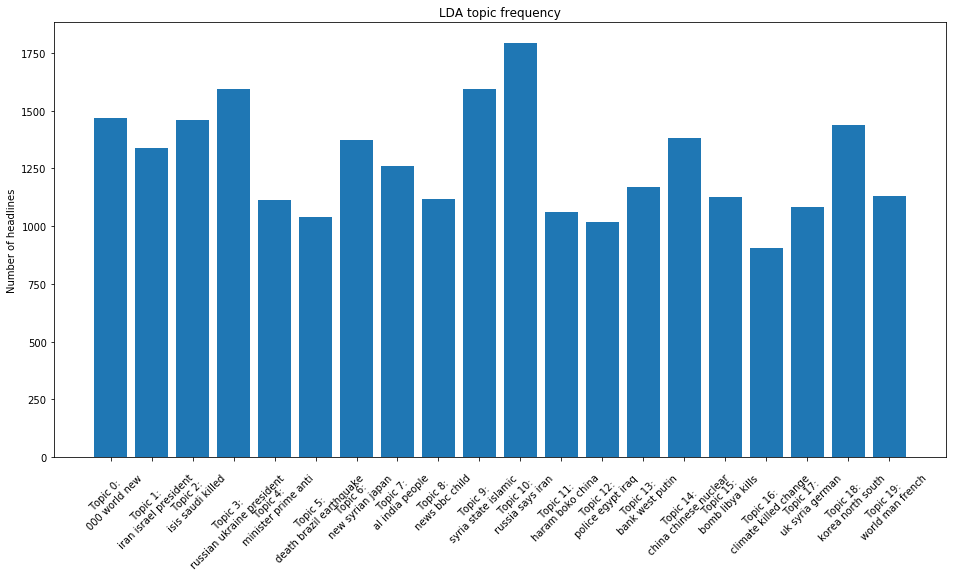

In [25]:
top_3_words = get_top_n_words(3, lda_keys, sampled_document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
plt.xticks(rotation=45)
ax.set_title('LDA topic frequency');
ax.set_ylabel('Number of headlines');

In [26]:
print "use t-SNE to visualize LDA high dimensional dataset"
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)


use t-SNE to visualize LDA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 25462 samples in 0.038s...
[t-SNE] Computed neighbors for 25462 samples in 53.273s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25462
[t-SNE] Computed conditional probabilities for sample 2000 / 25462
[t-SNE] Computed conditional probabilities for sample 3000 / 25462
[t-SNE] Computed conditional probabilities for sample 4000 / 25462
[t-SNE] Computed conditional probabilities for sample 5000 / 25462
[t-SNE] Computed conditional probabilities for sample 6000 / 25462
[t-SNE] Computed conditional probabilities for sample 7000 / 25462
[t-SNE] Computed conditional probabilities for sample 8000 / 25462
[t-SNE] Computed conditional probabilities for sample 9000 / 25462
[t-SNE] Computed conditional probabilities for sample 10000 / 25462
[t-SNE] Computed conditional probabilities for sample 11000 / 25462
[t-SNE] Computed conditional probabilities for sample 12000 / 25

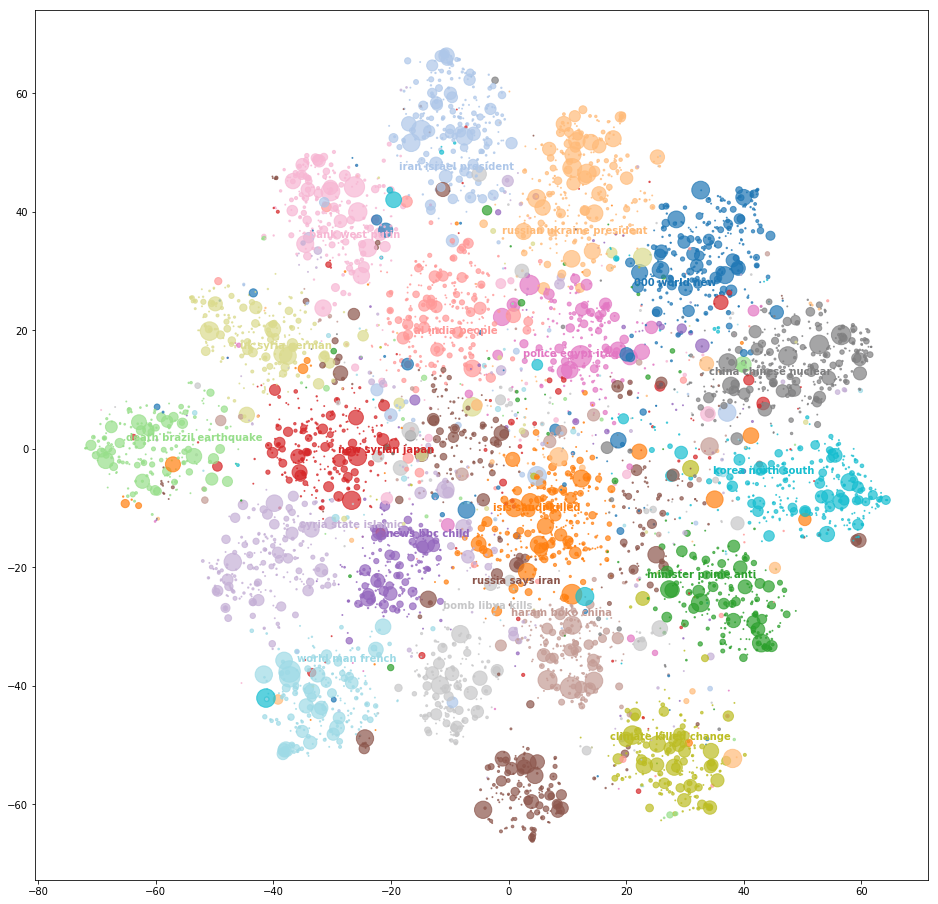

In [55]:
top_3_words_lda = get_top_n_words(3, lda_keys, sampled_document_term_matrix, count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)
fig, ax = plt.subplots(figsize=(16,16))
plt.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1],
            color=colormap[lda_keys],
            marker='o', s=sampled_up_votes_sizes, alpha=0.7)
for t in range(n_topics):
    plt.text(lda_mean_topic_vectors[t][0],
             lda_mean_topic_vectors[t][1],
             top_3_words[t], color=colormap[t],
             horizontalalignment='center', weight='bold')
plt.show()